In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
'''
db = '/srv/new_train/FinalDirectory/'
im_files = []
with open('/home/rahul/multi-scale-rmac/image_paths.txt','r') as f:
    for line in f:
        im_files.append(db+line.rstrip())
'''
db = './test_imgs/'
im_files = []
for im in os.listdir(db):
    im_files.append(db+im)


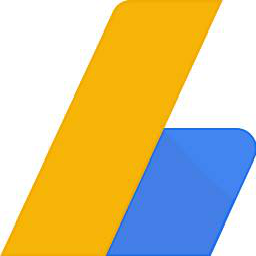

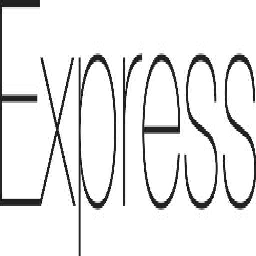

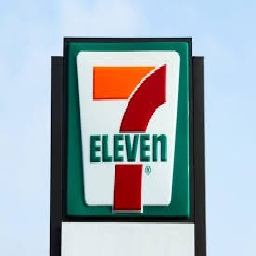

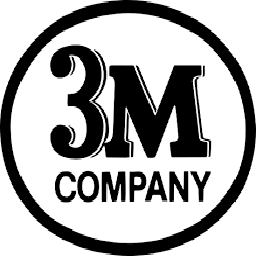

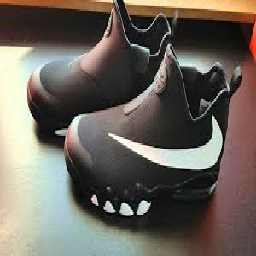

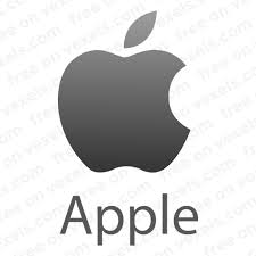

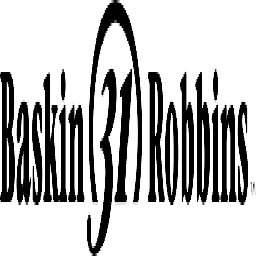

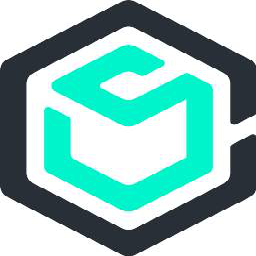

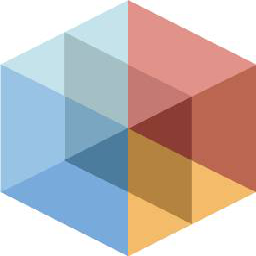

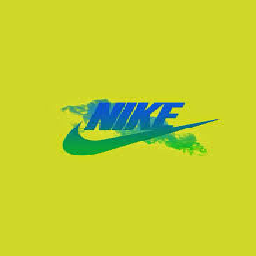

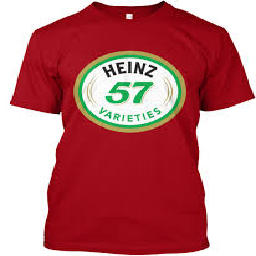

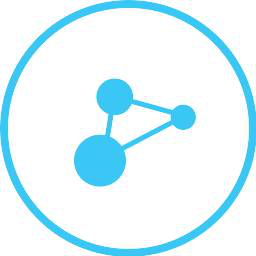

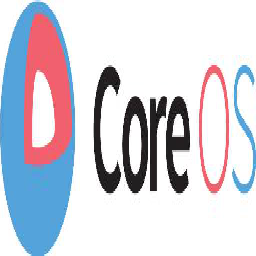

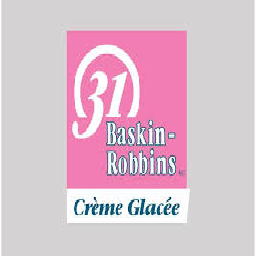

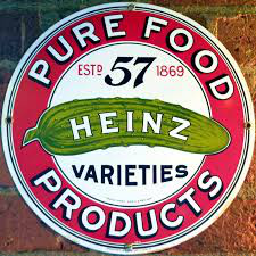

In [4]:
from PIL import Image
for imgs in im_files[50:70]:
    display(Image.open(imgs).resize((256,256)))

In [4]:
im = im_files[5]
MAX_SIZE = (256,256)
img = cv2.imread(im)
print(img.shape)
if img.shape[0]>MAX_SIZE[0] or img.shape[1]>MAX_SIZE[1]:
    img = cv2.resize(img, MAX_SIZE)
print(img.shape)
plt.imshow(img)

(159, 318, 3)
(256, 256, 3)


In [5]:
surf = cv2.xfeatures2d.SURF_create(450)
print(surf.getHessianThreshold())
kp, des = surf.detectAndCompute(img, None)

450.0


In [6]:
len(des)

138

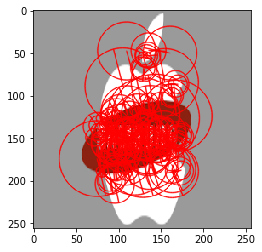

In [7]:
img2 = cv2.drawKeypoints(img, kp,None,(255,0,0),4)
plt.imshow(img2)

In [9]:
'''
sequential storage of surf features
'''

import h5py
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans

hdf = h5py.File('./SURF_cache2.hdf','a')
vecs = hdf.require_group('vectors')
#names = hdf.require_group('filenames')
dset = vecs.create_dataset('v', shape=(0,64),dtype=np.float32, maxshape=(None,64))
#dt = h5py.special_dtype(vlen=str)
#nset = names.create_dataset('f', shape=(0,), maxshape=(None,), dtype=dt)

In [15]:
import h5py
from tqdm import tqdm
from sklearn.cluster import KMeans

hdf = h5py.File('./SURF_cache2.hdf','r')
dset = hdf['vectors']['v']

In [16]:
'''
storing by filename
'''

hf = h5py.File('./SURF2.hdf','r')
#grp = hf.create_group('surf_vectors')
main_group = hf['surf_vectors']

In [25]:
'''
for i in tqdm(range(len(im_files))):
    try:
        main_group[im_files[i]]
    except KeyError as e:
        im_files.remove(im_files[i])
        continue
'''
hdf.close()
hf.close()


 32%|███▏      | 17267/54364 [05:39<10:36, 58.24it/s]

In [10]:
'''
for sequential hdf
'''

ims_removed = 0
for image in tqdm(im_files):
    #subgrp = grp.create_group(image)
    #data = subgrp.create_dataset('v', shape=(0,64),dtype=np.float32, maxshape=(None,64))
    cv_im = cv2.imread(image)
    #if cv_im.shape[0]>MAX_SIZE[0] or cv_im.shape[1]>MAX_SIZE[1]:
    cv_im = cv2.resize(cv_im, MAX_SIZE)
    kp, des = surf.detectAndCompute(cv_im, None)
    try:
        init_index = dset.shape[0]
        dset.resize((dset.shape[0]+des.shape[0], 64))
        dset[init_index:init_index+des.shape[0],:] = des
        #nset.resize((nset.shape[0]+des.shape[0],))
        #nset[init_index:init_index+des.shape[0]] = image
        hdf.flush()
    except AttributeError as e:
        print('Image returns no SURF features..skipping')
        im_files.remove(image)
        ims_removed += 1
        continue
hdf.close()

 11%|█         | 120/1128 [00:00<00:06, 144.48it/s]

Image returns no SURF features..skipping


 42%|████▏     | 479/1128 [00:03<00:04, 139.85it/s]

Image returns no SURF features..skipping


100%|█████████▉| 1126/1128 [00:07<00:00, 141.80it/s]


In [13]:
'''
for group by filename hdf
'''

ims_removed = 0
for image in tqdm(im_files):
    subgrp = grp.create_group(image)
    data = subgrp.create_dataset('v', shape=(0,64),dtype=np.float32, maxshape=(None,64))
    cv_im = cv2.imread(image)
    #if cv_im.shape[0]>MAX_SIZE[0] or cv_im.shape[1]>MAX_SIZE[1]:
    cv_im = cv2.resize(cv_im, MAX_SIZE)
    kp, des = surf.detectAndCompute(cv_im, None)
    try:
        init_index = data.shape[0]
        data.resize((data.shape[0]+des.shape[0], 64))
        data[init_index:init_index+des.shape[0],:] = des
        #nset.resize((nset.shape[0]+des.shape[0],))
        #nset[init_index:init_index+des.shape[0]] = image
        hf.flush()
    except AttributeError as e:
        print('Image returns no SURF features..skipping')
        im_files.remove(image)
        ims_removed += 1
        continue
hf.close()

100%|██████████| 1126/1126 [00:08<00:00, 139.09it/s]


In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

clustno = range(100,110)
kmeans = [MiniBatchKMeans(n_clusters=i, batch_size=5000) for i in clustno]
for r in tqdm(range(len(dset)//5000)):
    kmeans[0].partial_fit(dset[r*5000:(r+1)*5000])

'''
score = tqdm([kmeans[i].fit(dset).score(dset) for i in range(len(kmeans))])

plt.plot(clustno, score)
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Elbow curve')
plt.show()
'''


  3%|▎         | 1708/54364 [00:32<16:36, 52.84it/s]


  6%|▌         | 3307/54364 [01:03<14:36, 58.26it/s]


  9%|▉         | 5059/54364 [01:33<14:08, 58.13it/s]


 13%|█▎        | 6811/54364 [02:03<13:37, 58.18it/s]


 16%|█▌        | 8512/54364 [02:33<16:10, 47.23it/s]


 18%|█▊        | 9992/54364 [03:04<15:33, 47.56it/s]


 21%|██        | 11455/54364 [03:35<14:57, 47.81it/s]


 24%|██▎       | 12903/54364 [04:05<14:35, 47.34it/s]


 26%|██▋       | 14363/54364 [04:35<13:50, 48.16it/s]


 30%|██▉       | 16049/54364 [05:05<11:02, 57.83it/s]


 32%|███▏      | 17267/54364 [05:26<10:36, 58.24it/s]

KeyboardInterrupt: 

In [17]:
'''for i in tqdm(range(len(dset)//5000)):
    kmeans.partial_fit(dset[i*5000:(i+1)*5000])'''
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
kmeans.fit(dset)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
kmeans.cluster_centers_.shape

(100, 64)

In [21]:
100*64

6400

In [91]:
kmeans.predict(dset[0].reshape(1,64))[0]

14

In [90]:
hf['surf_vectors'][im_files[0]]['v'].shape

(95, 64)

In [19]:
from numba import njit

@njit
def Norm_scheme(vec):
    for elem in range(len(vec)):
        vec[elem] = np.sign(vec[elem])*np.sqrt(np.absolute(vec[elem]))
    vec = vec / np.sqrt(np.sum(vec**2))
    return vec   

In [22]:
def VLAD(fpath, hdf_obj):
    vladsurf = np.zeros((6400,))
    desc = hdf_obj['surf_vectors'][fpath]['v']
    for k in range(len(desc)):
        d = desc[k]
        cluster_id = kmeans.predict(d.reshape(1,64))[0]
        diff = d - kmeans.cluster_centers_[cluster_id]
        vladsurf[(cluster_id)*64:(cluster_id+1)*64] = vladsurf[(cluster_id)*64:(cluster_id+1)*64] + diff
        final = Norm_scheme(vladsurf)
    return final.astype('float32')

In [23]:
import faiss
index = faiss.IndexFlatL2(6400)
for r in tqdm(range(len(im_files))):
    try:
        index.add(VLAD(im_files[r], hf).reshape(1,6400))
    except UnboundLocalError as e:
        print('no surf features, skipping')
        continue
    
print(index.ntotal)
faiss.write_index(index, 'v_index.fvecs')

Loading faiss with AVX2 support.
100%|██████████| 1126/1126 [01:26<00:00, 12.95it/s]

1126


In [39]:
from time import time
t1 = time()
v = VLAD(im_files[3],hf)
print(time()-t1)

0.023975133895874023


In [60]:
v = VLAD(im_files[946], hf).reshape(1,6400)
K = 10
D, I = index.search(v, K)
indices = I.tolist()[0]
ranked_files = [im_files[i] for i in indices]

In [61]:
indices

[946, 416, 175, 950, 388, 608, 717, 541, 291, 996]

In [62]:
from PIL import Image
montage = Image.new('RGB', (2200,200))
x_coord = 0
y_coord = 0
ranked_files.insert(0,im_files[946])
for k in range(len(ranked_files)):
    im = Image.open(ranked_files[k])
    im.thumbnail((200,200))
    montage.paste(im, (x_coord,y_coord))
    x_coord += 200
    
montage.save('./montage.png')

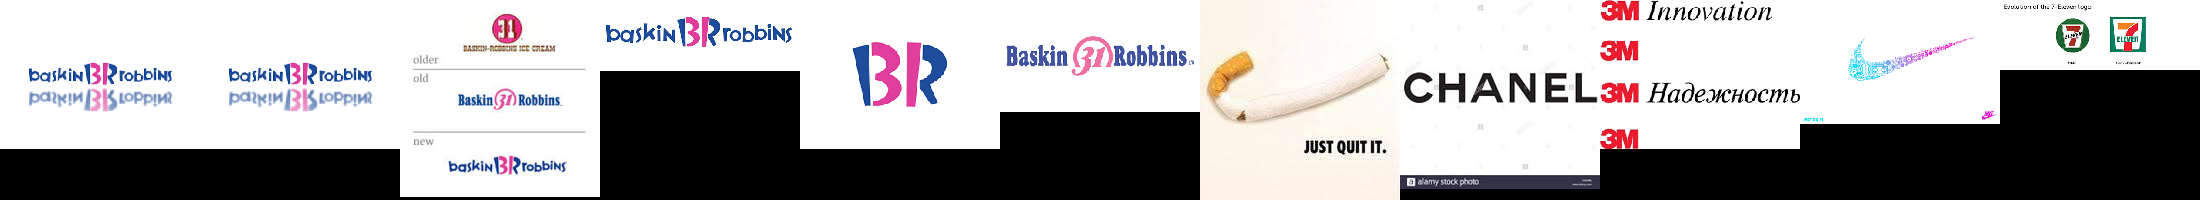

In [63]:
display(Image.open('./montage.png'))